# Visualizing the logs

In [25]:
import os
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from dotenv import load_dotenv
load_dotenv()

kaffe_file = os.getenv("KAFFE_LOG_FILE")
lunsj_file = os.getenv("LUNSJ_LOG_FILE")
konge_file = os.getenv("KONGE_LOG_FILE")
bordtennis_file = os.getenv("BORDTENNIS_LOG_FILE")

map_id_name = {...} # TODO: provide mapping of discord id to name

def get_data(filename):
    with open(filename, "r") as file:
        csvdata = csv.reader(file)
        data = [row for row in csvdata]
        cols_name = data[0] # first row should be the column names
        rows = data[1:]
        return {title: d for title, d in zip(cols_name, zip(*rows))}

In [35]:
def plot_timeseries_logs(filename):
    print(f"Plot of {filename}")
    data = get_data(filename)
    plot_title = filename.split("/")[1].split("_")[0] # given that we have the format logs/kaffe_logs.csv
    
    plt.style.use('_mpl-gallery')
    
    df_plot = pd.DataFrame({
           "timestamp": pd.to_datetime(list(data["timestamp"])),
           "duration": pd.to_numeric(list(data["duration"]), errors="coerce")
    }).dropna().sort_values("timestamp")
    
    x = df_plot["timestamp"]
    y = df_plot["duration"] / 60
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, y, linewidth=2)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    fig.autofmt_xdate()
    ax.set_xlabel("timestamp")
    ax.set_ylabel("duration in minutes")
    ax.set_title(f"Duration of {plot_title} breaks")
    
    plt.show()

def plot_konge_logs(filename):
    print(f"Plot of {filename}")
    data = get_data(filename)

    plt.style.use('_mpl-gallery')

    get_names = [map_id_name[id] for id in list(data["konge"])]
    get_counts = [get_names.count(name) for name in get_names]

    df_plot = pd.DataFrame({
           "konge": get_names,
           "count": get_counts
    }).dropna()

    x = df_plot["konge"]
    y = df_plot["count"]

    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(x, y, linewidth=20)

    ax.set_xlabel("konge")
    ax.set_ylabel("number of times")
    ax.set_title("Count of konge")
    
    plt.show()

Plot of logs/kaffe_log.csv


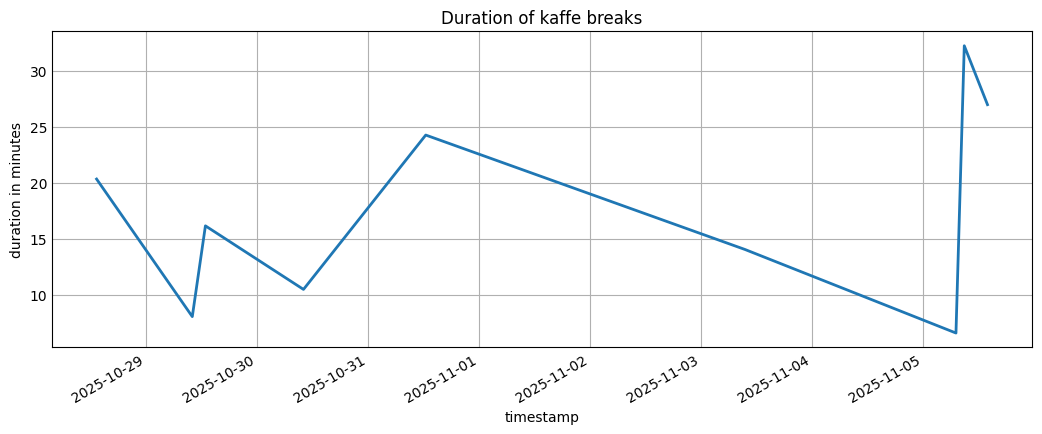

In [30]:
plot_timeseries_logs(kaffe_file)

Plot of logs/lunsj_log.csv


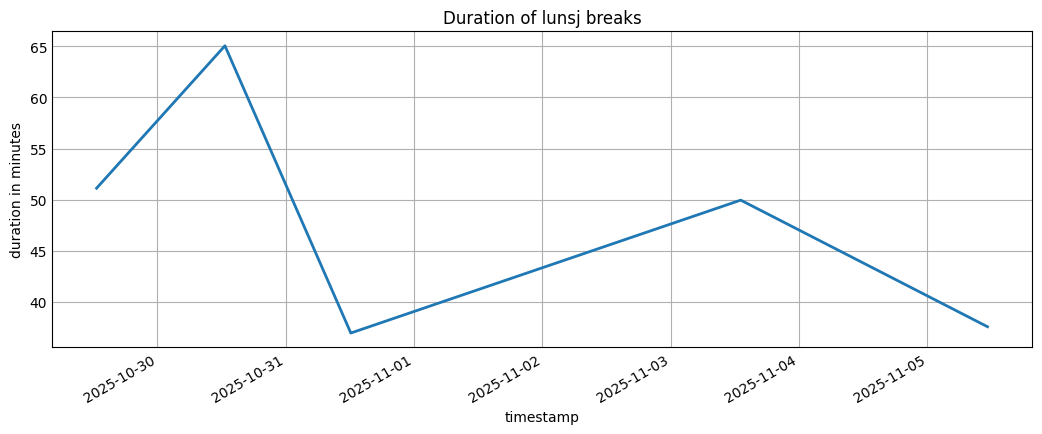

In [31]:
plot_timeseries_logs(lunsj_file)

Plot of logs/bordtennis_log.csv


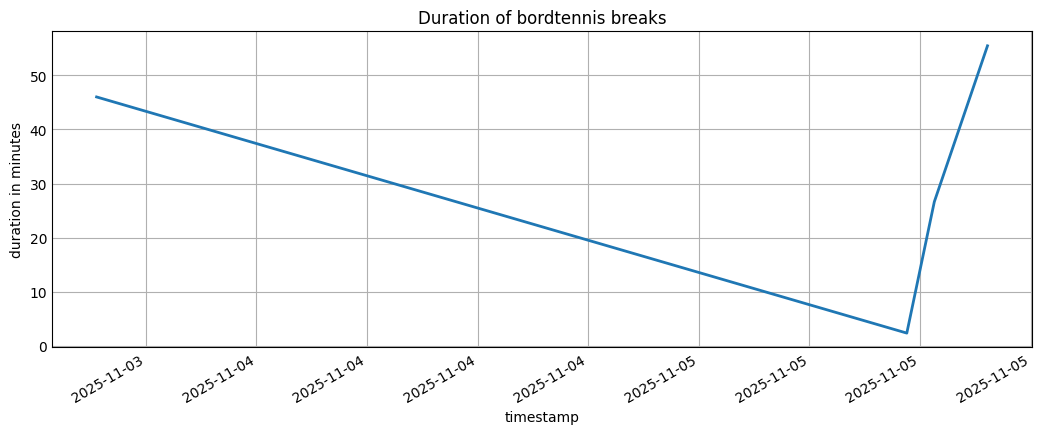

In [32]:
plot_timeseries_logs(bordtennis_file)